In [2]:
import networkx as nx 
import numpy as np
import torch 
import torch_geometric as torch_geo 
from torch_geometric.datasets import Planetoid, SNAPDataset
from torch_geometric.transforms import NormalizeFeatures


### <b>Node Classification Tasks</b>


#### Approach each of the following classification tasks using the following methods:

* classify nodes using only node features via FCN (use no graph information).
* classify nodes using both node features and ad-hoc graph variables for each node (e.g. for a given node use degree, centrality measures, sum of words of the neighbors, etc as features).
    * note: this is really the baseline to which one should compare e.g. GCN, n2v.
* classify nodes using only graph structure via node2vec (don’t use features for nodes).
* classify nodes using both graph structure and node features by concatenating node2vec embeddings and node features.
* classify nodes using GCN (using both node features and graph structure).

#### Requirements
1. Explore different architectures and hyperparameters. 
2. Compare these models for each classification problem, using standard metrics (accuracy, precision, recall) and a thoughtful data analysis (e.g. are false positives more often high degree nodes?). 
    - For node2vec and GCN, plot the dense vector embeddings and try to interpret them (e.g. use tSNE to plot the embeddings, colored by label or node degree).

#### Side Note: Testing on different types of graph
Your classification problems should always be tested in circumstances similar to how the algorithm be used! Graph problems will either be:
1. Transductive, when the graph structure is fixed ahead of time, but the labels remain unknown. 
    * e.g. given a fixed set of publications, can you classify them for an analysis?
2. Inductive, when the graph evolves/changes post-training.
    * e.g. a publisher has a service: when an author uploads their paper, the algorithm recommends a category/tag for labeling the paper.

#### Two Datasets
1. CORA: building off of last week's material 
    * Tip: start writing library functions automating portions for the next task.

2. Choose another dataset from SNAP for node classification 
    * Describe a real world situation where this node classification would be useful (is it inductive or transductive?).



### Dataset#1: CORA

In [3]:
# data loading function for CORA
def loader_cora_torch(filepath="../data/raw/Planetoid", transform=None, batch_size=1, shuffle=False):
    """Return the CORA dataset"""
    dataset = Planetoid(root=filepath, name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000, transform=transform) # return a class of datasets
    data = dataset[0]
    # print some dataset statistics 
    print(f'Loads Cora dataset, at root location: {filepath}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    # create adjacency matrix (for graph feature)
    adj_mat = torch_geo.utils.to_dense_adj(data.edge_index) 

    return adj_mat[0], data.x, data.y


graph_features, node_features, labels = loader_cora_torch(shuffle=True) # load the cora dataset

# split data sets into training, validation, testing 
train_node_features, val_node_features, test_node_features = node_features[:20], node_features[20:1220], node_features[1220:]
train_graph_features, val_graph_features, test_graph_features = graph_features[:20], graph_features[20:1220], graph_features[1220:]
train_node_labels, val_node_labels, test_node_labels = labels[:20], labels[20:1220], labels[1220:]


Loads Cora dataset, at root location: ../data/raw/Planetoid
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


##### classify nodes using only node features via FCN (use no graph information).

In [4]:
# FCN 

# first one only have 1 layer
class FCN_v1(torch.nn.Module):
    def __init__(self, input_shape, output_shape, device=None):
        super(FCN_v1, self).__init__()

        if device == None: 
            device = torch.device('cpu')

        self.Linear = torch.nn.Linear(in_features=input_shape, out_features=output_shape, device=device)
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, X): 
        output = self.Linear(X)
        output = self.softmax(output)
        return output

# this one has 2 layer (1 input, 1 hidden)
class FCN_v2(torch.nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, device=None):
        super(FCN_v2, self).__init__()

        if device == None: 
            device = torch.device('cpu')

        self.Linear = torch.nn.Linear(in_features=input_shape, out_features=hidden_shape, device=device)
        self.relu = torch.nn.ReLU()
        self.hidden_Linear = torch.nn.Linear(in_features=hidden_shape, out_features=output_shape, device=device)
        self.softmax = torch.nn.Softmax(0)
    
    def forward(self, X): 
        output = self.Linear(X)
        output = self.relu(output)
        output = self.hidden_Linear(output)
        output = self.softmax(output)
        return output

In [7]:
# specify optimizers, loss, and training process 
model_1 = FCN_v1(train_node_features.shape[1], 7)
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 100
PATH = "./cache/FCN_1.pt"

model_1_trainloss, model_1_valloss = [], [] 
model_1_valacc = []

# Training loops
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # training 
    model_1.train(True)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_node_features):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data, train_node_labels[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_1(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
        # running_loss = 0.0
    print(f"Training Loss {epoch}", total_loss/(i+1))
    # save training loss for the epoch
    model_1_trainloss.append(total_loss/(i+1))

    # validation
    model_1.train(False)
    total_vloss = 0.0
    true_pairs = 0
    for i, data in enumerate(val_node_features):
        inputs, labels = data, val_node_labels[i]
        outputs = model_1(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        total_vloss += loss
        if torch.argmax(outputs) == labels: 
            true_pairs +=1
    
    # save validation loss for the epoch
    model_1_valloss.append(total_vloss/len(val_node_features))
    model_1_valacc.append(true_pairs/len(val_node_features))
    if epoch == num_epoch-1:
        print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

print('Finished Training')

# save model parameters 
torch.save(model_1.state_dict(), PATH)


Training Loss 0 1.9437646687030792
Training Loss 1 1.9400173366069793
Training Loss 2 1.9355647623538972
Training Loss 3 1.9307990372180939
Training Loss 4 1.9257511615753173
Training Loss 5 1.920407485961914
Training Loss 6 1.9147481620311737
Training Loss 7 1.9087521016597748
Training Loss 8 1.9023976445198059
Training Loss 9 1.895663356781006
Training Loss 10 1.8885285198688506
Training Loss 11 1.8809739470481872
Training Loss 12 1.8729829728603362
Training Loss 13 1.8645427942276
Training Loss 14 1.8556456089019775
Training Loss 15 1.8462902307510376
Training Loss 16 1.8364832520484924
Training Loss 17 1.8262404441833495
Training Loss 18 1.815587431192398
Training Loss 19 1.8045599579811096
Training Loss 20 1.7932035326957703
Training Loss 21 1.7815719246864319
Training Loss 22 1.7697255432605743
Training Loss 23 1.757728737592697
Training Loss 24 1.7456470727920532
Training Loss 25 1.733544397354126
Training Loss 26 1.721480667591095
Training Loss 27 1.7095096230506897
Training Lo

In [8]:
# specify optimizers, loss, and training process 
model_2 = FCN_v2(train_node_features.shape[1], train_node_features.shape[1]//2, 7)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 100
PATH = "./cache/FCN_2.pt"

model_2_trainloss, model_2_valloss = [], [] 
model_2_valacc = []

# Training loops
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # training 
    model_2.train(True)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_node_features):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data, train_node_labels[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
        # running_loss = 0.0
    print(f"Training Loss {epoch}", total_loss/(i+1))
    # save training loss for the epoch
    model_2_trainloss.append(total_loss/(i+1))

    # validation
    model_2.train(False)
    total_vloss = 0.0
    true_pairs = 0
    for i, data in enumerate(val_node_features):
        inputs, labels = data, val_node_labels[i]
        outputs = model_2(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        total_vloss += loss
        if torch.argmax(outputs) == labels: 
            true_pairs +=1
    
    # save validation loss for the epoch
    model_2_valloss.append(total_vloss/len(val_node_features))
    model_2_valacc.append(true_pairs/len(val_node_features))
    if epoch == num_epoch-1:
        print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

print('Finished Training')

# save model parameters 
torch.save(model_2.state_dict(), PATH)


Training Loss 0 1.9460958003997804
Training Loss 1 1.9446190476417542
Training Loss 2 1.9428920686244964
Training Loss 3 1.9411014080047608
Training Loss 4 1.93926540017128
Training Loss 5 1.9373839259147645
Training Loss 6 1.9354551196098329
Training Loss 7 1.9334755778312682
Training Loss 8 1.9314413905143737
Training Loss 9 1.9293478071689605
Training Loss 10 1.927188366651535
Training Loss 11 1.9249565184116364
Training Loss 12 1.9226493060588836
Training Loss 13 1.9202623426914216
Training Loss 14 1.9177872776985168
Training Loss 15 1.9152118802070617
Training Loss 16 1.9125298798084258
Training Loss 17 1.909731376171112
Training Loss 18 1.9068037211894988
Training Loss 19 1.9037353634834289
Training Loss 20 1.9005115449428558
Training Loss 21 1.8971179902553559
Training Loss 22 1.8935372710227967
Training Loss 23 1.8897495925426484
Training Loss 24 1.8857325434684753
Training Loss 25 1.8814681470394135
Training Loss 26 1.876928734779358
Training Loss 27 1.8720885574817658
Trainin

In [9]:
# plot the result of both models 
import matplotlib.pyplot as plt 
def plot_result(train_loss, val_loss, val_acc):
    plt.plot(train_loss, color='blue')
    plt.plot([i.cpu().data for i in val_loss], color='orange')
    plt.show()

    plt.plot(val_acc, color='green')
    plt.show()

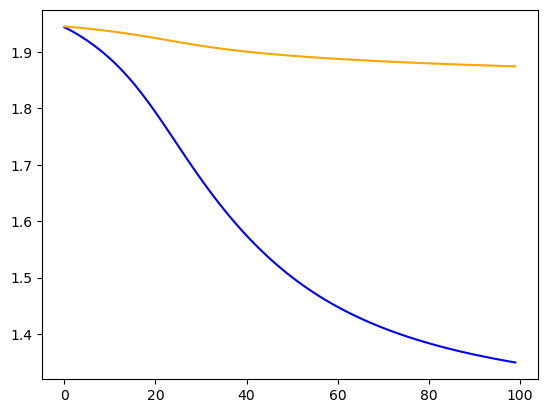

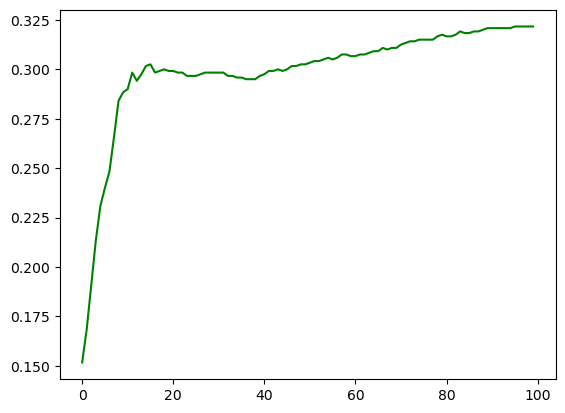

In [10]:
# plot the result of both models 
import matplotlib.pyplot as plt 
plt.plot(model_1_trainloss, color='blue')
plt.plot([i.cpu().data for i in model_1_valloss], color='orange')
plt.show()

plt.plot(model_1_valacc, color='green')
plt.show()

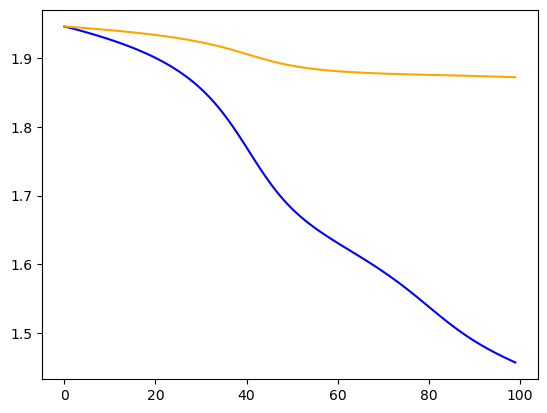

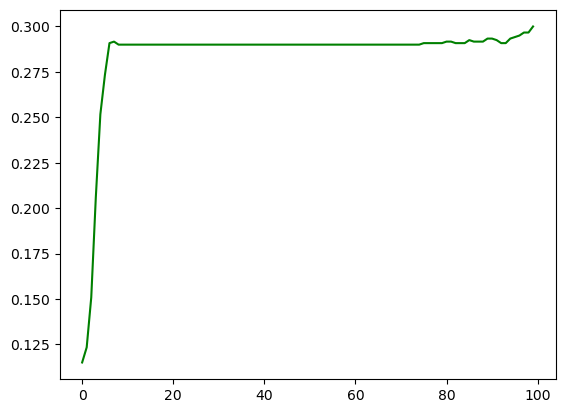

In [11]:
# plot the result of both models 
import matplotlib.pyplot as plt 
plt.plot(model_2_trainloss, color='blue')
plt.plot([i.cpu().data for i in model_2_valloss], color='orange')
plt.show()

plt.plot(model_2_valacc, color='green')
plt.show()

In [13]:
# test testing statistics
def test_acc(model, test_features, test_labels): 
    model.train(False)
    outputs = model(test_features)
    test_acc = np.mean((torch.argmax(outputs, dim=1) == test_node_labels).numpy())
    print("Test accuracy is ", test_acc)
    return test_acc

model_1.train(False)
outputs = model_1(test_node_features)
test_acc_result = np.mean((torch.argmax(outputs, dim=1) == test_node_labels).numpy())
print("Test accuracy is ", test_acc_result)

model_2.train(False)
outputs = model_2(test_node_features)
test_acc_result = np.mean((torch.argmax(outputs, dim=1) == test_node_labels).numpy())
print("Test accuracy is ", test_acc_result)

Test accuracy is  0.27956989247311825
Test accuracy is  0.2668010752688172


#### classify nodes using both node features and ad-hoc graph variables for each node (e.g. for a given node use degree, centrality measures, sum of words of the neighbors, etc as features).

In [73]:
# Add ad-hoc graph variables as input features
import networkx as nx

G = nx.from_numpy_matrix(graph_features.numpy())
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality = torch.tensor(list(closeness_centrality.values()))
new_features = torch.cat([node_features, torch.sum(node_features, dim=1)[:, None], torch.sum(graph_features, dim=1)[:, None], torch.unsqueeze(closeness_centrality, dim=1)], dim=1)

In [74]:
train, validation, test = new_features[:20], new_features[20:1220], new_features[1220:]

Training Loss 0 1.8428294360637665
Training Loss 1 1.7151447057723999
Training Loss 2 1.7020224034786224
Training Loss 3 1.7000542521476745
Training Loss 4 1.6993195593357087
Training Loss 5 1.6987811863422393
Training Loss 6 1.6982979357242585
Training Loss 7 1.6978406131267547
Training Loss 8 1.6973979771137238
Training Loss 9 1.6969635367393494
Training Loss 10 1.6965325891971588
Training Loss 11 1.696101826429367
Training Loss 12 1.6956686556339264
Training Loss 13 1.6952311038970946
Training Loss 14 1.6947876274585725
Training Loss 15 1.6943369328975677
Training Loss 16 1.6938779771327972
Training Loss 17 1.6934098839759826
Training Loss 18 1.6929317712783813
Training Loss 19 1.6924431145191192
Training Loss 20 1.6919430851936341
Training Loss 21 1.6914312362670898
Training Loss 22 1.6909069538116455
Training Loss 23 1.6903697490692138
Training Loss 24 1.689819073677063
Training Loss 25 1.6892544031143188
Training Loss 26 1.6886752784252166
Training Loss 27 1.6880812764167785
Trai

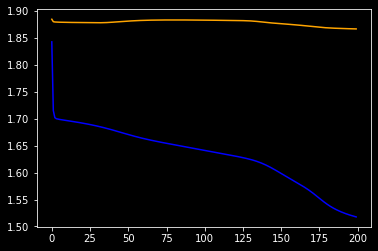

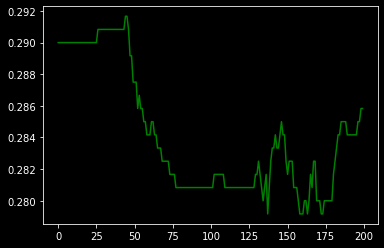

Test accuracy is  0.198252688172043


0.198252688172043

In [95]:
# specify optimizers, loss, and training process 
model_3 = FCN_v1(train.shape[1], 7)
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 200
PATH = "./cache/FCN_1.pt"

model_3_trainloss, model_3_valloss = [], [] 
model_3_valacc = []

# Training loops
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # training 
    model_3.train(True)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data, train_node_labels[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_3(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
        # running_loss = 0.0
    print(f"Training Loss {epoch}", total_loss/(i+1))
    # save training loss for the epoch
    model_3_trainloss.append(total_loss/(i+1))

    # validation
    model_3.train(False)
    total_vloss = 0.0
    true_pairs = 0
    for i, data in enumerate(validation):
        inputs, labels = data, val_node_labels[i]
        outputs = model_3(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        total_vloss += loss
        if torch.argmax(outputs) == labels: 
            true_pairs +=1
    
    # save validation loss for the epoch
    model_3_valloss.append(total_vloss/len(val_node_features))
    model_3_valacc.append(true_pairs/len(val_node_features))
    if epoch == num_epoch-1:
        print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

print('Finished Training')

# save model parameters 
torch.save(model_3.state_dict(), PATH)

plot_result(model_3_trainloss, model_3_valloss, model_3_valacc)

test_acc(model_3, test, test_labels)

#### classify nodes using only graph structure via node2vec (don’t use features for nodes).

In [100]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

data = Planetoid(root="../data/raw/Planetoid", name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000)[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                    context_size=10, walks_per_node=10,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True,
                        num_workers=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                        z[data.test_mask], data.y[data.test_mask],
                        max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


Epoch: 01, Loss: 9.5785, Acc: 0.1620
Epoch: 02, Loss: 9.5697, Acc: 0.1620
Epoch: 03, Loss: 9.5757, Acc: 0.1620
Epoch: 04, Loss: 9.5567, Acc: 0.1620
Epoch: 05, Loss: 9.5776, Acc: 0.1620
Epoch: 06, Loss: 9.5883, Acc: 0.1620
Epoch: 07, Loss: 9.5691, Acc: 0.1620
Epoch: 08, Loss: 9.5674, Acc: 0.1620
Epoch: 09, Loss: 9.6098, Acc: 0.1620
Epoch: 10, Loss: 9.5790, Acc: 0.1620
Epoch: 11, Loss: 9.5589, Acc: 0.1620
Epoch: 12, Loss: 9.5788, Acc: 0.1620
Epoch: 13, Loss: 9.5670, Acc: 0.1620
Epoch: 14, Loss: 9.5782, Acc: 0.1620
Epoch: 15, Loss: 9.5819, Acc: 0.1620
Epoch: 16, Loss: 9.5999, Acc: 0.1620
Epoch: 17, Loss: 9.5524, Acc: 0.1620
Epoch: 18, Loss: 9.5530, Acc: 0.1620
Epoch: 19, Loss: 9.5696, Acc: 0.1620
Epoch: 20, Loss: 9.5745, Acc: 0.1620
Epoch: 21, Loss: 9.5656, Acc: 0.1620
Epoch: 22, Loss: 9.5668, Acc: 0.1620
Epoch: 23, Loss: 9.5814, Acc: 0.1620
Epoch: 24, Loss: 9.5899, Acc: 0.1620
Epoch: 25, Loss: 9.5999, Acc: 0.1620
Epoch: 26, Loss: 9.5838, Acc: 0.1620
Epoch: 27, Loss: 9.5751, Acc: 0.1620
E

/Users/barryxue/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/barryxue/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


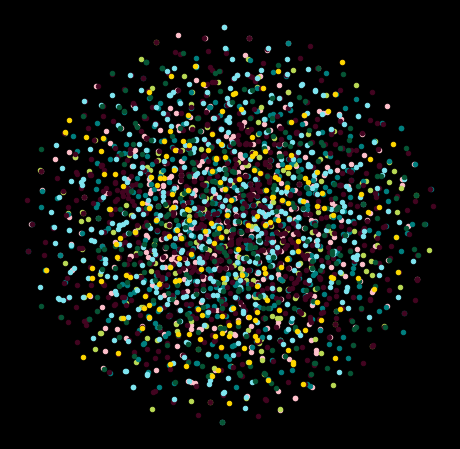

In [103]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(7):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

This implementation of node2vec performs really bad for some reason.

#### classify nodes using both graph structure and node features by concatenating node2vec embeddings and node features.

In [107]:
test_acc_wfeature = model.test(torch.cat([model()[data.train_mask], data.x[data.train_mask]], dim=1), data.y[data.train_mask],
                        torch.cat([model()[data.val_mask], data.x[data.val_mask]], dim=1), data.y[data.val_mask],
                        max_iter=150)
test_acc_wfeature

0.192

#### GCN with Graph features

In [115]:
# from scipy.linalg import fractional_matrix_power
# class GCNLayer(torch.nn.Module):
#     """ Custom Linear layer but mimics a standard linear layer """
#     def __init__(self, A, input_dim, output_dim, device):
#         super(GCNLayer, self).__init__()
#         print("layer initialized")
#         self.device = device # initialize the hosting device

#         self.A = A.to(self.device) # the adjacency matrix 
#         self.I = torch.eye(self.A.shape[0], device=self.device) # create identity matrix with the same shape as A 
#         self.A =  self.A + self.I   # add self loop to A 
#         # print("Adj Matrix with self loop: ", self.A)
#         self.D = torch.diag(torch.sum(self.A, dim=0)).cpu()  # calculate the degree matrix with A after added self loop
#         # print("Degree Matrix: ", self.D)
#         # for diagonal matrix, raising it to any power is the same as raising its diagonal elements to that power
#         # we can just apply the -1/2 power to all element of this degree matrix 
#         # self.D_half_norm = torch.reciprocal(torch.sqrt(self.D)) 
#         self.D_half_norm = torch.from_numpy(fractional_matrix_power(self.D, -0.5)).to(self.device)
#         # print("Normalization Matrix: ", self.D_half_norm)
#         self.A_s = torch.mm(torch.mm(self.D_half_norm, self.A), self.D_half_norm).to(self.device) # normalized adjacency matrix

#         # initialize the weight matrix for this layer 
#         # the weight should have shape of (N , F) where N is the size of the input, and F is the output dimension
#         self.W = torch.nn.Parameter(
#             data=(torch.rand(input_dim, output_dim, device=self.device) * 0.01),  # times it by 0.001 to make the weight smaller
#             requires_grad=True, # weight should be trainable 
#         )
#         # create trainable a bias term for the layer
#         self.b = torch.nn.Parameter(
#             data=(torch.rand(output_dim, 1, device=self.device) * 0.01),
#             requires_grad=True, # bias should be trainable 
#         )

#         # print(self.W.get_device(), self.b.get_device())

#     def forward(self, H):
#         # print(H.get_device())
#         return torch.mm(torch.mm(self.A_s, H.unsqueeze(dim=1)).T, self.W).T + self.b

# # create a 1 layer classification model with softmax output
# class twoLayerGCN(torch.nn.Module): 
#     def __init__(self, adjacency_matrix, hidden_size,  output_size, device) -> None:
#         """
#         Parameters: 
#             adjacency_matrix: tensor, a tensor representing the link connection between nodes
#             output_size: input, the number of target label we have for our prediction
#         """
#         super(twoLayerGCN, self).__init__()
#         self.device=device
#         self.A = adjacency_matrix
#         self.output_size = output_size
#         self.hidden_size = hidden_size
#         self.hidden_conv_layer = GCNLayer(A=self.A, input_dim=self.A.shape[0], output_dim=self.hidden_size, device=self.device)
#         self.relu = torch.nn.ReLU()
#         self.output_layer = GCNLayer(A=self.A, input_dim=self.hidden_size, output_dim=self.output_size, device=self.device)
#         self.softmax = torch.nn.Softmax()

#     def forward(self, X): 
#         """
#         Parameters: 
#             X: tensor, the link feature of the nodes in the dataset
#         """
#         output = self.hidden_conv_layer(X).T # get the hidden embedding
#         # print("Hidden Layer Output:", output)
#         output = self.relu(output)
#         output = self.output_layer(output).T
#         output = self.softmax(output)
#         # print("Softmax Output: ", output)
#         return output


In [127]:
# from torch_geometric.nn import Sequential, GCNConv, Linear, SoftmaxAggregation
# from torch.nn import ReLU, Softmax

# dataset = Planetoid(root="../data/raw/Planetoid", name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000)[0]
# # adj_mat = torch.ones((train_graph_features.shape[1]+train_node_features.shape[1], train_graph_features.shape[1]+train_node_features.shape[1]))
# # adj_mat[:train_graph_features.shape[1], :train_graph_features.shape[1]] = torch_geo.utils.to_dense_adj(dataset.edge_index)[0]
# # print(adj_mat.shape)
# model_6 = Sequential('x, edge_index', [
#     (GCNConv(int(train_graph_features.shape[1] + train_node_features.shape[1]), 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     (GCNConv(64, 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     Linear(64, 7),
#     Softmax(dim=0)
# ])

# # model_6 = twoLayerGCN(adjacency_matrix=adj_mat, hidden_size = 64, output_size=7, device=torch.device('cpu'))

# optimizer = torch.optim.SGD(model_6.parameters(), lr=0.001, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()
# num_epoch = 200
# PATH = "./cache/GCN_1.pt"

# model_6_trainloss, model_6_valloss = [], [] 
# model_6_valacc = []

# # Training loops
# for epoch in range(num_epoch):  # loop over the dataset multiple times
#     # training 
#     model_6.train(True)
#     total_loss = 0.0
#     running_loss = 0.0
#     for i, data in enumerate(torch.cat([train_graph_features, train_node_features], dim=1)):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data, train_node_labels[i]

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model_6(inputs, dataset.edge_index)
#         # outputs = torch.unsqueeze(outputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         total_loss += loss.item()
        
#         # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
#         # running_loss = 0.0
#     print(f"Training Loss {epoch}", total_loss/(i+1))
#     # save training loss for the epoch
#     model_6_trainloss.append(total_loss/(i+1))

#     # validation
#     model_6.train(False)
#     total_vloss = 0.0
#     true_pairs = 0
#     for i, data in enumerate(torch.cat([val_graph_features, val_node_features], dim=1)):
#         inputs, labels = data, val_node_labels[i]
#         outputs = model_6(inputs, dataset.edge_index)
#         # outputs = torch.unsqueeze(outputs)
#         loss = criterion(outputs, labels)
#         total_vloss += loss
#         if torch.argmax(outputs) == labels: 
#             true_pairs +=1
    
#     # save validation loss for the epoch
#     model_6_valloss.append(total_vloss/len(val_node_features))
#     model_6_valacc.append(true_pairs/len(val_node_features))
#     if epoch == num_epoch-1:
#         print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

# print('Finished Training')

# # save model parameters 
# torch.save(model_6.state_dict(), PATH)

# plot_result(model_6_trainloss, model_6_valloss, model_6_valacc)

# def test_acc_GCN(model, edge_index, test_features, test_labels): 
#     model.train(False)
#     outputs = model(test_features, edge_index)
#     test_acc = np.mean((torch.argmax(outputs, dim=1) == test_node_labels).numpy())
#     print("Test accuracy is ", test_acc)
#     return test_acc

# test_acc_GCN(model_6, dataset.edge_index, torch.cat([test_graph_features, test_node_features], dim=1), test_node_labels)

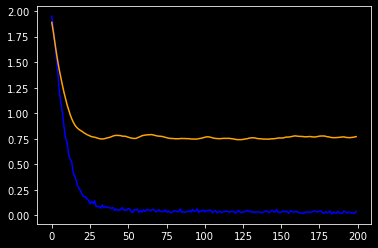

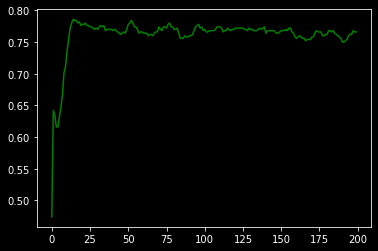

Test Accuracy: 0.8000


In [136]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root="../data/raw/Planetoid", name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000)

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_loss, val_loss, val_acc = [], [], []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    model.eval()
    output = model(data)
    vloss = F.nll_loss(output[data.val_mask], data.y[data.val_mask])

    train_loss.append(loss.detach().numpy())
    val_loss.append(vloss.detach())
    val_acc.append(np.mean((torch.argmax(output[data.val_mask], dim=1) == data.y[data.val_mask]).detach().numpy()))

plot_result(train_loss, val_loss, val_acc)

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')

#### Dataset#2: PubMed

In [2]:
import networkx as nx 
import numpy as np
import torch 
import torch_geometric as torch_geo 
from torch_geometric.datasets import Planetoid, SNAPDataset
from torch_geometric.transforms import NormalizeFeatures

In [27]:
# data loading function for CORA
def loader_pubmed_torch(filepath="../data/raw/Planetoid", transform=None, batch_size=1, shuffle=False):
    """Return the CORA dataset"""
    dataset = Planetoid(root=filepath, name='PubMed', split='public', num_train_per_class=20, num_val=500, num_test=1000, transform=transform) # return a class of datasets
    data = dataset[0]
    # print some dataset statistics 
    print(f'Loads Cora dataset, at root location: {filepath}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    # create adjacency matrix (for graph feature)
    adj_mat = torch_geo.utils.to_dense_adj(data.edge_index) 

    return adj_mat[0], data.x, data.y


graph_features, node_features, labels = loader_pubmed_torch(shuffle=True) # load the cora dataset

# split data sets into training, validation, testing 
split1, split2 = 50, (19717-50)//2+50
train_node_features, val_node_features, test_node_features = node_features[:split1], node_features[split1:split2], node_features[split2:]
train_graph_features, val_graph_features, test_graph_features = graph_features[:split1], graph_features[split1:split2], graph_features[split2:]
train_node_labels, val_node_labels, test_node_labels = labels[:split1], labels[split1:split2], labels[split2:]


Loads Cora dataset, at root location: ../data/raw/Planetoid
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
# FCN 

# first one only have 1 layer
class FCN_v1(torch.nn.Module):
    def __init__(self, input_shape, output_shape, device=None):
        super(FCN_v1, self).__init__()

        if device == None: 
            device = torch.device('cpu')

        self.Linear = torch.nn.Linear(in_features=input_shape, out_features=output_shape, device=device)
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, X): 
        output = self.Linear(X)
        output = self.softmax(output)
        return output

In [28]:
# specify optimizers, loss, and training process 
model_1 = FCN_v1(train_node_features.shape[1], 7)
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 200
PATH = "./cache/FCN_1.pt"

model_1_trainloss, model_1_valloss = [], [] 
model_1_valacc = []

# Training loops
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # training 
    model_1.train(True)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_node_features):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data, train_node_labels[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_1(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
        # running_loss = 0.0
    print(f"Training Loss {epoch}", total_loss/(i+1))
    # save training loss for the epoch
    model_1_trainloss.append(total_loss/(i+1))

    # validation
    model_1.train(False)
    total_vloss = 0.0
    true_pairs = 0
    for i, data in enumerate(val_node_features):
        inputs, labels = data, val_node_labels[i]
        outputs = model_1(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        total_vloss += loss
        if torch.argmax(outputs) == labels: 
            true_pairs +=1
    
    # save validation loss for the epoch
    model_1_valloss.append(total_vloss/len(val_node_features))
    model_1_valacc.append(true_pairs/len(val_node_features))
    if epoch == num_epoch-1:
        print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

print('Finished Training')

# save model parameters 
torch.save(model_1.state_dict(), PATH)


Training Loss 0 1.947804958820343
Training Loss 1 1.9455790686607362
Training Loss 2 1.9432679748535155
Training Loss 3 1.9409278893470765
Training Loss 4 1.9385597944259643
Training Loss 5 1.936164379119873
Training Loss 6 1.933742482662201
Training Loss 7 1.9312949919700622
Training Loss 8 1.9288228940963745
Training Loss 9 1.9263272094726562
Training Loss 10 1.9238090538978576
Training Loss 11 1.9212696385383605
Training Loss 12 1.9187102174758912
Training Loss 13 1.9161321640014648
Training Loss 14 1.9135368061065674
Training Loss 15 1.9109257221221925
Training Loss 16 1.9083004069328309
Training Loss 17 1.905662477016449
Training Loss 18 1.9030136108398437
Training Loss 19 1.9003555011749267
Training Loss 20 1.897689917087555
Training Loss 21 1.8950186920166017
Training Loss 22 1.8923436141014098
Training Loss 23 1.889666576385498
Training Loss 24 1.8869894385337829
Training Loss 25 1.8843141460418702
Training Loss 26 1.8816425490379334
Training Loss 27 1.8789765310287476
Training

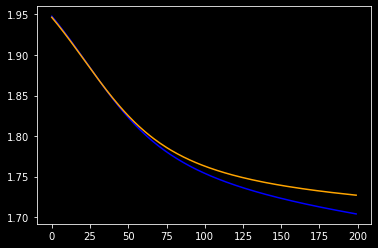

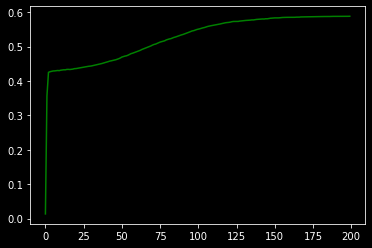

Test accuracy is  0.5941631075859264


In [29]:
# plot the result of both models 
import matplotlib.pyplot as plt 
def plot_result(train_loss, val_loss, val_acc):
    plt.plot(train_loss, color='blue')
    plt.plot([i.cpu().data for i in val_loss], color='orange')
    plt.show()

    plt.plot(val_acc, color='green')
    plt.show()

# test testing statistics
def test_acc(model, test_features, test_labels): 
    model.train(False)
    outputs = model(test_features)
    test_acc = np.mean((torch.argmax(outputs, dim=1) == test_node_labels).numpy())
    print("Test accuracy is ", test_acc)
    return test_acc

plot_result(model_1_trainloss, model_1_valloss, model_1_valacc)
test_a = test_acc(model_1, test_node_features, test_node_labels)

In [34]:
# Add ad-hoc graph variables as input features
import networkx as nx

G = nx.from_numpy_matrix(graph_features.numpy())
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality = torch.tensor(list(closeness_centrality.values()))
new_features = torch.cat([node_features, torch.sum(node_features, dim=1)[:, None], torch.sum(graph_features, dim=1)[:, None], torch.unsqueeze(closeness_centrality, dim=1)], dim=1)

train, validation, test = new_features[:split1], new_features[split1:split2], new_features[split2:]

Training Loss 0 1.9438380932807922
Training Loss 1 1.8950378203392029
Training Loss 2 1.8640236783027648
Training Loss 3 1.8479450607299805
Training Loss 4 1.8350615286827088
Training Loss 5 1.8238284802436828
Training Loss 6 1.813877763748169
Training Loss 7 1.8052629661560058
Training Loss 8 1.7977825450897216
Training Loss 9 1.791155436038971
Training Loss 10 1.7852433657646178
Training Loss 11 1.7799487590789795
Training Loss 12 1.775190896987915
Training Loss 13 1.7709031987190247
Training Loss 14 1.7670294666290283
Training Loss 15 1.7635220646858216
Training Loss 16 1.7603398156166077
Training Loss 17 1.757447190284729
Training Loss 18 1.754812979698181
Training Loss 19 1.752409794330597
Training Loss 20 1.750213532447815
Training Loss 21 1.7482025289535523
Training Loss 22 1.7463577127456664
Training Loss 23 1.7446618795394897
Training Loss 24 1.7430996775627137
Training Loss 25 1.7416573929786683
Training Loss 26 1.7403227019309997
Training Loss 27 1.7390845966339112
Training 

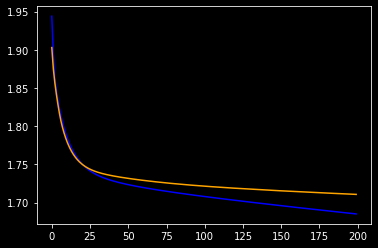

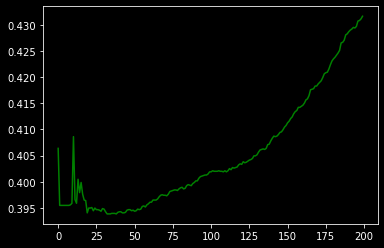

Test accuracy is  0.1089078706528371


0.1089078706528371

In [35]:
# specify optimizers, loss, and training process 
model_3 = FCN_v1(train.shape[1], 7)
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 200
PATH = "./cache/FCN_1.pt"

model_3_trainloss, model_3_valloss = [], [] 
model_3_valacc = []

# Training loops
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # training 
    model_3.train(True)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data, train_node_labels[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_3(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss:.3f}')
        # running_loss = 0.0
    print(f"Training Loss {epoch}", total_loss/(i+1))
    # save training loss for the epoch
    model_3_trainloss.append(total_loss/(i+1))

    # validation
    model_3.train(False)
    total_vloss = 0.0
    true_pairs = 0
    for i, data in enumerate(validation):
        inputs, labels = data, val_node_labels[i]
        outputs = model_3(inputs)
        # outputs = torch.unsqueeze(outputs)
        loss = criterion(outputs, labels)
        total_vloss += loss
        if torch.argmax(outputs) == labels: 
            true_pairs +=1
    
    # save validation loss for the epoch
    model_3_valloss.append(total_vloss/len(val_node_features))
    model_3_valacc.append(true_pairs/len(val_node_features))
    if epoch == num_epoch-1:
        print(f"Validation Accuracy {epoch}: ", true_pairs/len(val_node_features))

print('Finished Training')

# save model parameters 
torch.save(model_3.state_dict(), PATH)

plot_result(model_3_trainloss, model_3_valloss, model_3_valacc)

test_acc(model_3, test, test_node_labels)

Epoch: 01, Loss: 9.7327, Acc: 0.3150
Epoch: 02, Loss: 9.7348, Acc: 0.3150
Epoch: 03, Loss: 9.7306, Acc: 0.3150
Epoch: 04, Loss: 9.7302, Acc: 0.3150
Epoch: 05, Loss: 9.7327, Acc: 0.3150
Epoch: 06, Loss: 9.7348, Acc: 0.3150
Epoch: 07, Loss: 9.7334, Acc: 0.3150
Epoch: 08, Loss: 9.7321, Acc: 0.3150
Epoch: 09, Loss: 9.7351, Acc: 0.3150
Epoch: 10, Loss: 9.7289, Acc: 0.3150
Epoch: 11, Loss: 9.7315, Acc: 0.3150
Epoch: 12, Loss: 9.7297, Acc: 0.3150
Epoch: 13, Loss: 9.7255, Acc: 0.3150
Epoch: 14, Loss: 9.7289, Acc: 0.3150
Epoch: 15, Loss: 9.7311, Acc: 0.3150
Epoch: 16, Loss: 9.7281, Acc: 0.3150
Epoch: 17, Loss: 9.7216, Acc: 0.3150
Epoch: 18, Loss: 9.7185, Acc: 0.3150
Epoch: 19, Loss: 9.7302, Acc: 0.3150
Epoch: 20, Loss: 9.7314, Acc: 0.3150
Epoch: 21, Loss: 9.7307, Acc: 0.3150
Epoch: 22, Loss: 9.7320, Acc: 0.3150
Epoch: 23, Loss: 9.7302, Acc: 0.3150
Epoch: 24, Loss: 9.7233, Acc: 0.3150
Epoch: 25, Loss: 9.7271, Acc: 0.3150
Epoch: 26, Loss: 9.7302, Acc: 0.3150
Epoch: 27, Loss: 9.7296, Acc: 0.3150
E

/Users/barryxue/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/barryxue/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


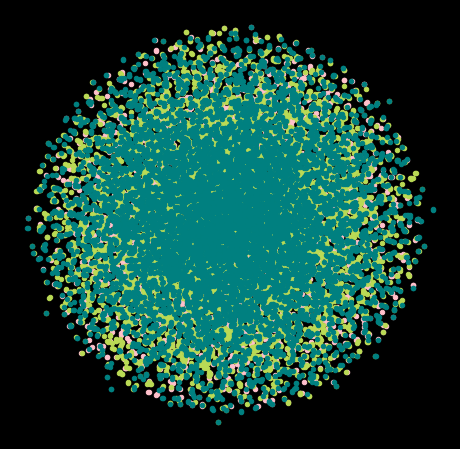

In [36]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

data = Planetoid(root="../data/raw/Planetoid", name='PubMed', split='public', num_train_per_class=20, num_val=500, num_test=1000)[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                    context_size=10, walks_per_node=10,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True,
                        num_workers=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                        z[data.test_mask], data.y[data.test_mask],
                        max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(7):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

In [37]:
test_acc_wfeature = model.test(torch.cat([model()[data.train_mask], data.x[data.train_mask]], dim=1), data.y[data.train_mask],
                        torch.cat([model()[data.val_mask], data.x[data.val_mask]], dim=1), data.y[data.val_mask],
                        max_iter=150)
test_acc_wfeature

0.352

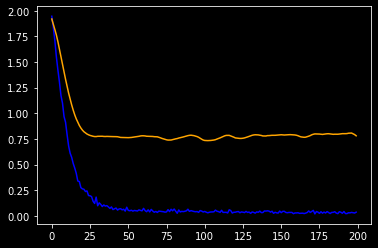

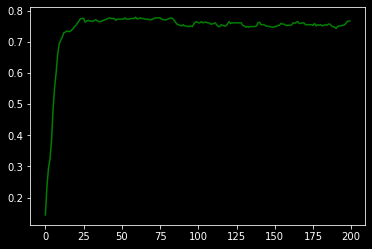

Test Accuracy: 0.7970


In [38]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root="../data/raw/Planetoid", name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000)

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_loss, val_loss, val_acc = [], [], []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    model.eval()
    output = model(data)
    vloss = F.nll_loss(output[data.val_mask], data.y[data.val_mask])

    train_loss.append(loss.detach().numpy())
    val_loss.append(vloss.detach())
    val_acc.append(np.mean((torch.argmax(output[data.val_mask], dim=1) == data.y[data.val_mask]).detach().numpy()))

plot_result(train_loss, val_loss, val_acc)

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')